# Introduction

Machine learning (ML) workflows orchestrate and automate sequences of ML tasks by enabling activities such as:
- data collection and transformation, 
- model training, testing, evaluation and tuning
- online/offline access to the model's predictive capabilities via an API.

In this notebook, a cloud-based ML worflow is proposed using as example the well-known [breast cancer Winsconsin diagnostics dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

It is assumed that the data has been cleaned and prepared beforehand. Likewise, data exploration and feature engineering are left out of the scope of this notebook. *We will focus solely on data ingestion, model building and model serving aspects of the worflow.*

# Proposed AWS Cloud Infrastructure

<img src="./notebook_images/AWS_infra.png">

# Imports

In [1]:
import warnings

from joblib import dump
from datetime import date

import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# Data Ingestion

In [2]:
# Load and show data from breast cancer dataset.
bc_dataset = load_breast_cancer()
bc_df = pd.DataFrame(data=bc_dataset.data, columns=bc_dataset.feature_names)
bc_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Automated Model Training

I'll keep `train_test_split` parameters as close to default as possible, but still reproductible with random_state and test_size manually set`

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width=500 height=500>

In [3]:
# Split train and test data.
X = bc_dataset.data
y = bc_dataset.target
class_names = bc_dataset.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [4]:
# Filter warning from GridSearchCV.
warnings.filterwarnings('ignore')

# Grid search parameteres setup.
param_grid = {
    'criterion':['gini', 'entropy'],
    'splitter':['best', 'random'],
    'max_features':['sqrt', 'log2', None],
}

# Run grid search on a Decision Tree model.
clf = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='precision_macro',
    cv=10,
    n_jobs=4
)

# Fit best Decision Tree model according to the grid search.
clf.fit(X_train, y_train);

# Model Evaluation

In [5]:
# See best estimator's parameteres.
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [6]:
# Set up confusion matrix.
y_pred = clf.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred))

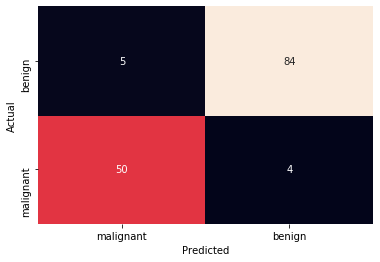

In [7]:
# Plot confusion matrix.
sn.heatmap(df_cm, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names).set_ylim([0,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Save Trained Model

In [10]:
# Save trained model and append today's date to its filename.
datetime_string = date.today().strftime("%Y_%m_%d")
dump(clf.best_estimator_, f'../automated_workflow/api/saved_models/saved_model_{datetime_string}.joblib')

['../automated_workflow/api/saved_models/saved_model_2020_02_14.joblib']